# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [7]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [8]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [9]:
n_noise = 100

In [10]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [12]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [13]:
batch_size = 64

In [14]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [15]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [16]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [17]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [18]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [19]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 100, D Loss: 1.1755154132843018, G Loss: 0.8270020484924316
Epoch: 0/50, Step: 200, D Loss: 1.4079020023345947, G Loss: 0.8065428137779236
Epoch: 0/50, Step: 300, D Loss: 1.2308564186096191, G Loss: 1.0008032321929932
Epoch: 0/50, Step: 400, D Loss: 1.2088241577148438, G Loss: 0.5426709651947021
Epoch: 0/50, Step: 500, D Loss: 1.3081212043762207, G Loss: 1.6697196960449219
Epoch: 0/50, Step: 600, D Loss: 1.2405954599380493, G Loss: 1.3488750457763672
Epoch: 0/50, Step: 700, D Loss: 1.1216254234313965, G Loss: 1.313636302947998
Epoch: 0/50, Step: 800, D Loss: 0.9928608536720276, G Loss: 1.1896991729736328
Epoch: 0/50, Step: 900, D Loss: 1.055720329284668, G Loss: 1.3114458322525024
Epoch: 1/50, Step: 1000, D Loss: 1.1775424480438232, G Loss: 1.30094313621521
Epoch: 1/50, Step: 1100, D Loss: 1.2202109098434448, G Loss: 0.6925904154777527
Epoch: 1/50, Step: 1200, D Loss: 1.0529544353485107, G Loss: 0.7519501447677612
Epoch: 1/50, Step: 1300, D Loss: 1.221968412399292, G

Epoch: 21/50, Step: 20300, D Loss: 1.1523170471191406, G Loss: 0.8529489636421204
Epoch: 21/50, Step: 20400, D Loss: 1.2152249813079834, G Loss: 0.9573037624359131
Epoch: 21/50, Step: 20500, D Loss: 1.2426687479019165, G Loss: 0.9399197101593018
Epoch: 21/50, Step: 20600, D Loss: 1.136208415031433, G Loss: 0.9436594843864441
Epoch: 22/50, Step: 20700, D Loss: 1.1527689695358276, G Loss: 0.9725241661071777
Epoch: 22/50, Step: 20800, D Loss: 1.192220687866211, G Loss: 0.7522275447845459
Epoch: 22/50, Step: 20900, D Loss: 1.346964955329895, G Loss: 0.5827013254165649
Epoch: 22/50, Step: 21000, D Loss: 1.22269868850708, G Loss: 0.8253107070922852
Epoch: 22/50, Step: 21100, D Loss: 1.3469669818878174, G Loss: 1.181819200515747
Epoch: 22/50, Step: 21200, D Loss: 1.265282154083252, G Loss: 0.6865647435188293
Epoch: 22/50, Step: 21300, D Loss: 1.2427411079406738, G Loss: 0.7111386060714722
Epoch: 22/50, Step: 21400, D Loss: 1.1825366020202637, G Loss: 1.1427326202392578
Epoch: 22/50, Step: 215

Epoch: 43/50, Step: 40300, D Loss: 1.2671339511871338, G Loss: 0.8715578317642212
Epoch: 43/50, Step: 40400, D Loss: 1.1369638442993164, G Loss: 0.9362446665763855
Epoch: 43/50, Step: 40500, D Loss: 1.200079083442688, G Loss: 1.1189543008804321
Epoch: 43/50, Step: 40600, D Loss: 1.3150529861450195, G Loss: 0.7439093589782715
Epoch: 43/50, Step: 40700, D Loss: 1.2304681539535522, G Loss: 0.7889236807823181
Epoch: 43/50, Step: 40800, D Loss: 1.3195154666900635, G Loss: 0.69771808385849
Epoch: 43/50, Step: 40900, D Loss: 1.237633228302002, G Loss: 0.8163778781890869
Epoch: 43/50, Step: 41000, D Loss: 1.2536416053771973, G Loss: 1.062206506729126
Epoch: 43/50, Step: 41100, D Loss: 1.3234291076660156, G Loss: 0.8421131372451782
Epoch: 43/50, Step: 41200, D Loss: 1.2624945640563965, G Loss: 1.0797982215881348
Epoch: 44/50, Step: 41300, D Loss: 1.3040547370910645, G Loss: 0.8745784759521484
Epoch: 44/50, Step: 41400, D Loss: 1.248758316040039, G Loss: 0.819257915019989
Epoch: 44/50, Step: 415

## Visualize Sample

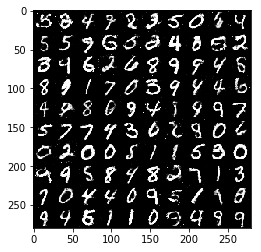

In [20]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [14]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')